Energy Demand Prediction
==============
This notebook aims to predict the aggregate energy demand from a selected list of locations in the City of Helsinki using both the classical Box-Jenkins method and an advanced Deep Learning model. 

The data is fetched from the [Nuuka open API](https://helsinki-openapi.nuuka.cloud/swagger/index.html#/), courtesy of [Avoindata.fi](avoindata.fi). Visit our Github repository at [github.com/quan-possible/energy-demand-prediction](https://github.com/quan-possible/energy-demand-prediction).

Authors: [Bruce Nguyen](https://github.com/quan-possible) and [Son Le](https://github.com/SonAlexLe)

## Table of Contents
1. [Exploratory Data Analysis](#1.)
    1. [Data Cleaning](#1.1.)
    2. [Data Visualization](#1.2.)
2. [Baseline Model](#2.)
3. [SARIMAX](#3.)
    1. [Model Identification](#3.1.)
    2. [Model Estimation](#3.2.)
    3. [Model Validation](#3.3.)
1. [LSTM](#4.)
    1. [Feature Engineering](#4.1.)
        1. [Holidays Data Generation](#4.1.1.)
        2. [Cyclical feature encoding](#4.1.2.)
        3. [Feature Vector Normalization](#4.1.3.)
    2. [Modeling](#4.2.)
3. [Further Readings](#5.)

## Exploratory Data Analysis <a class="anchor" id="1."></a>

In [1]:
import numpy as np
import pandas as pd
import datetime # manipulating date formats
import os

from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose,STL

# settings
plt.style.use('seaborn-deep')

### Data Cleaning <a class="anchor" id="1.1."></a>

We start by reading the data and try to get familiar with it.

In [2]:
ts = pd.read_csv("daily.csv", parse_dates=['timestamp'])
ts

,Unnamed: 0,timestamp,reportingGroup,locationName,value,unit
0,0,2017-01-01,Electricity,1037 Vuotalo,1652.32,kWh
1,1,2017-01-02,Electricity,1037 Vuotalo,2145.28,kWh
2,2,2017-01-03,Electricity,1037 Vuotalo,2151.84,kWh
3,3,2017-01-04,Electricity,1037 Vuotalo,2489.12,kWh
4,4,2017-01-05,Electricity,1037 Vuotalo,2596.96,kWh
...,...,...,...,...,...,...
615229,615229,2019-12-28,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",349.73,kWh
615230,615230,2019-12-29,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",306.35,kWh
615231,615231,2019-12-30,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",253.59,kWh
615232,615232,2019-12-31,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",275.06,kWh


In [3]:
print(ts.info())
ts.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615234 entries, 0 to 615233
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Unnamed: 0      615234 non-null  int64         
 1   timestamp       615234 non-null  datetime64[ns]
 2   reportingGroup  615234 non-null  object        
 3   locationName    615234 non-null  object        
 4   value           615234 non-null  float64       
 5   unit            615234 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 28.2+ MB
None


,Unnamed: 0,value
count,615234.000000,615234.000000
mean,307616.500000,915.019259
std,177602.902095,1942.878510
min,0.000000,0.000000
25%,153808.250000,156.880000
50%,307616.500000,358.200000
75%,461424.750000,895.105000
max,615233.000000,35463.010000


From what we can see, the data contains the electricity consumption from various locations in Helsinki in the time period in question. However, since we are interested only in the aggregate demand by date (without location), the task is to sum up the values from those locations.

In order to do that, we need to get more information about the eneregy consumption from each location and remove any abnormality, if need be.

In [4]:
ts.groupby(['reportingGroup','unit','locationName'])['locationName'].count()

reportingGroup  unit  locationName                                                        
Electricity     kWh   1000 Hakaniemen kauppahalli                                             1089
                      1001 Hietalahden kauppahalli                                            1092
                      1002 Vanha kauppahalli                                                  1092
                      1037 Vuotalo                                                            1084
                      1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen                  1092
                                                                                              ... 
                      6492 Kontukuja 5, Kontulan monipuolinen palvelukeskus                   1092
                      6743 Kivikonkuja 4, terveydenhuollon päätearkisto                       1018
                      6760 Kaupunkiympäristön toimiala, 44572 Kaupunkiympäristön toimitalo     286
                  

Unfortunately, we can see that there are many problems with the data by looking at the view we created. The most obvious one is that the unit is not the same for all the data points. In fact, only one place has its electricity measured in $m^{3}$. We can fix this with a simple mask.

In [5]:
ts = ts[ts['unit'] != 'm3']
ts

,Unnamed: 0,timestamp,reportingGroup,locationName,value,unit
0,0,2017-01-01,Electricity,1037 Vuotalo,1652.32,kWh
1,1,2017-01-02,Electricity,1037 Vuotalo,2145.28,kWh
2,2,2017-01-03,Electricity,1037 Vuotalo,2151.84,kWh
3,3,2017-01-04,Electricity,1037 Vuotalo,2489.12,kWh
4,4,2017-01-05,Electricity,1037 Vuotalo,2596.96,kWh
...,...,...,...,...,...,...
615229,615229,2019-12-28,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",349.73,kWh
615230,615230,2019-12-29,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",306.35,kWh
615231,615231,2019-12-30,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",253.59,kWh
615232,615232,2019-12-31,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",275.06,kWh


In addition, the number of recorded values are not the same for all the locations, meaning that there are missing values for each location. This will take a bit more effort, starting with creating a new `DataFrame` consisting only the locations as columns.

In [6]:
groups = ts.groupby('locationName')

# divide into different dataframes for each location
locs = [groups.get_group(df).set_index('timestamp').value for df in groups.groups]

# remove duplicated rows
locs = [df[~df.index.duplicated(keep='first')] for df in locs]

ts = pd.concat(locs, join='outer', axis=1, ignore_index=True)
ts

,0,1,2,3,4,5,6,7,8,9,...,571,572,573,574,575,576,577,578,579,580
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2005.76,969.10,233.00,1652.32,1023.70,258.63,91.08,559.20,0.94,225.60,...,567.42,1181.76,1081.59,1069.2,703.99,4700.0,5264.00,670.37,NaN,1131.0
2017-01-02,3081.50,995.34,788.95,2145.28,1508.15,457.95,214.32,634.51,0.95,525.04,...,1152.73,1653.48,1436.20,1459.6,1244.22,8900.0,5976.00,875.44,NaN,2512.0
2017-01-03,3176.77,1122.91,1067.80,2151.84,1501.27,477.70,208.48,682.64,0.94,550.96,...,1211.86,1674.48,1496.60,1184.4,1275.65,9300.0,6056.00,882.21,NaN,2620.0
2017-01-04,3173.77,956.25,1125.55,2489.12,1497.33,484.12,215.52,693.18,0.95,545.52,...,1119.05,1630.08,1471.29,1211.2,885.92,11900.0,5916.00,837.58,NaN,3277.0
2017-01-05,3204.18,932.25,1217.55,2596.96,1431.18,476.02,221.72,702.17,0.95,536.56,...,1048.96,1553.52,1426.89,1236.8,850.15,13000.0,5800.00,805.91,NaN,3810.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,64.18,1184.67,693.20,2563.72,1363.52,343.14,72.44,612.14,0.00,189.92,...,401.63,554.88,924.79,1090.4,847.90,5660.0,4879.04,618.41,1435.52,2461.0
2019-12-29,1.51,886.31,420.55,2406.35,1257.60,289.67,73.00,645.90,0.00,189.12,...,398.91,555.60,927.02,1044.4,997.44,4420.0,4821.19,624.39,1399.04,1795.0
2019-12-30,2.28,1084.05,399.30,2760.30,1863.64,499.47,146.72,537.75,0.00,405.12,...,843.78,686.88,1526.55,1774.0,1476.41,5610.0,5421.80,689.85,2330.24,1428.0


The `NaN` values are now visible, now we only need to decide what to do with them. Our approach is to drop columns (locations) where there are more than 100 missing entries, since such columns are not significant to our analysis anymore.

In [7]:
ts = ts.loc[:,ts.isna().sum() < 100]
ts.head()

,0,1,2,3,4,5,6,7,9,10,...,570,571,572,573,574,575,576,577,578,580
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2005.76,969.10,233.00,1652.32,1023.70,258.63,91.08,559.20,225.60,379.89,...,98.48,567.42,1181.76,1081.59,1069.2,703.99,4700.0,5264.0,670.37,1131.0
2017-01-02,3081.50,995.34,788.95,2145.28,1508.15,457.95,214.32,634.51,525.04,457.54,...,340.96,1152.73,1653.48,1436.20,1459.6,1244.22,8900.0,5976.0,875.44,2512.0
2017-01-03,3176.77,1122.91,1067.80,2151.84,1501.27,477.70,208.48,682.64,550.96,447.20,...,342.88,1211.86,1674.48,1496.60,1184.4,1275.65,9300.0,6056.0,882.21,2620.0
2017-01-04,3173.77,956.25,1125.55,2489.12,1497.33,484.12,215.52,693.18,545.52,546.25,...,301.68,1119.05,1630.08,1471.29,1211.2,885.92,11900.0,5916.0,837.58,3277.0
2017-01-05,3204.18,932.25,1217.55,2596.96,1431.18,476.02,221.72,702.17,536.56,456.44,...,276.08,1048.96,1553.52,1426.89,1236.8,850.15,13000.0,5800.0,805.91,3810.0


Concerning the rest of the columns, we can just interpolate the missing values linearly. This method is simple but effective, given that the number of missing points is nominal.

In [8]:
ts = ts.sort_index().interpolate()
ts.head()

,0,1,2,3,4,5,6,7,9,10,...,570,571,572,573,574,575,576,577,578,580
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2005.76,969.10,233.00,1652.32,1023.70,258.63,91.08,559.20,225.60,379.89,...,98.48,567.42,1181.76,1081.59,1069.2,703.99,4700.0,5264.0,670.37,1131.0
2017-01-02,3081.50,995.34,788.95,2145.28,1508.15,457.95,214.32,634.51,525.04,457.54,...,340.96,1152.73,1653.48,1436.20,1459.6,1244.22,8900.0,5976.0,875.44,2512.0
2017-01-03,3176.77,1122.91,1067.80,2151.84,1501.27,477.70,208.48,682.64,550.96,447.20,...,342.88,1211.86,1674.48,1496.60,1184.4,1275.65,9300.0,6056.0,882.21,2620.0
2017-01-04,3173.77,956.25,1125.55,2489.12,1497.33,484.12,215.52,693.18,545.52,546.25,...,301.68,1119.05,1630.08,1471.29,1211.2,885.92,11900.0,5916.0,837.58,3277.0
2017-01-05,3204.18,932.25,1217.55,2596.96,1431.18,476.02,221.72,702.17,536.56,456.44,...,276.08,1048.96,1553.52,1426.89,1236.8,850.15,13000.0,5800.0,805.91,3810.0


The only step left is to aggregate all the values into a single 'energy consumption' column. We will also rename the columns for convenience.

In [9]:
ts= ts.sum(axis=1).to_frame(name='kWh')
ts.index.rename('Date',inplace=True)

<AxesSubplot:xlabel='Date'>

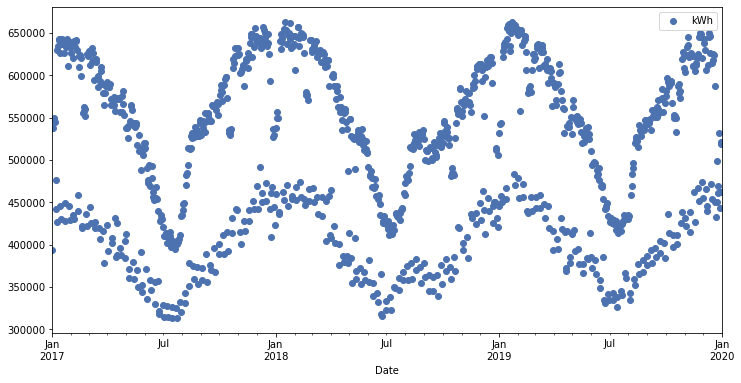

In [10]:
ts.plot(figsize = (12,6),style = 'o')

Finally, the data is in our desired shape. We only need to save our work now.

In [11]:
file_name = 'cleaned-daily.csv'
ts.to_csv(f"./{file_name}")

### Data Visualization <a class="anchor" id="1.2."></a>

First, we can take a look at the consumption during each year.

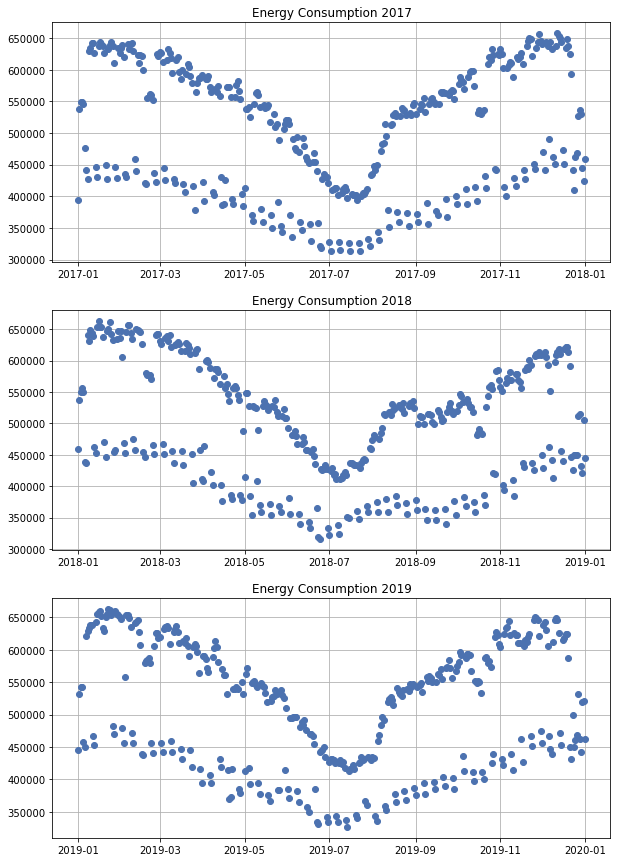

In [12]:
ts2017,ts2018,ts2019 = ts['2017-01-01':'2018-01-01'],ts['2018-01-01':'2019-01-01'],ts['2019-01-01':'2020-01-01']
figs,ax =  plt.subplots(3,figsize=(10,15))


ax[0].plot(ts2017,'o')
ax[0].set_title('Energy Consumption 2017')
ax[0].grid(True)
ax[1].plot(ts2018,'o')
ax[1].set_title('Energy Consumption 2018')
ax[1].grid(True)
ax[2].plot(ts2019,'o')
ax[2].set_title('Energy Consumption 2019')
ax[2].grid(True)

plt.show()

The seasonality within each year is very much predictable. The demand peaks in winter-spring then bottoms out during summer.

Let us proceed to zoom in the plot further and investigate monthly, weekly and daily time periods.

Text(0.5, 0.98, 'Energy Consumption in January 2017')

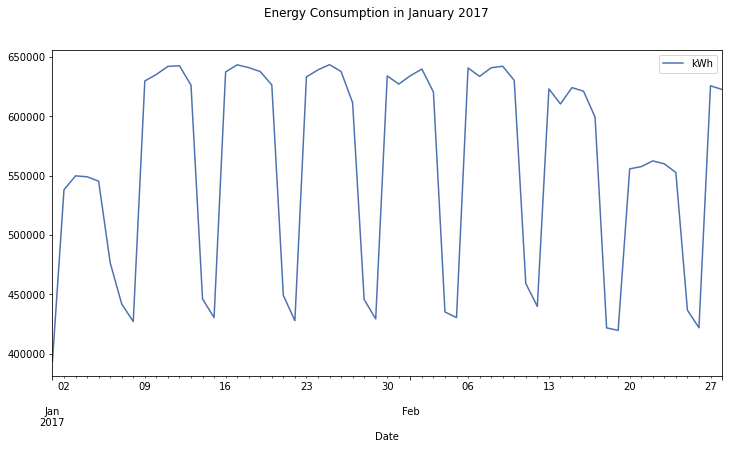

In [13]:
feb_end = '2017-02-28'

ts.loc[:feb_end].plot(figsize = (12,6))
plt.suptitle('Energy Consumption in January 2017')

Upon examining the plot, we can see that there is a very visible pattern that repeats itself every 7 days. Therefore, it can be deduced that there is a weekly seasonality within the time series. We can further explore this pattern by looking at the days of the weeks during the time period.

In [14]:
# The day of the week with Monday=0,..., Sunday=6
ts.loc[:feb_end].index.dayofweek

Int64Index([6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6,
            0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0,
            1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1],
           dtype='int64', name='Date')

From the result, we can see that energy consumption level is at its height during the weekdays, then drops significantly during the weekends. This very much fits our expectation, since factories and workplaces, which follow such a schedule, are places that consume the most energy.

In the following section, we will further investigate the time series by decomposing it in to the 3 components:
* Trend-cycle - increases or decreases within the data in the long-term or not of a fixed frequency. 
* Seasonal - pattern occurs when a time series is affected by seasonal factors.
* Residuals - the remainder after removing the 2 aforementioned components.

If we are looking at an additive decomposition, this can be mathematically formulated as
$$
y_t = S_t + T_t + R_t,
$$
where $y_t$ is the data, $S_t$ is the seasonal component, $T_t$ is the trend-cycle component, and $R_t$ is the remainder component, all at period $t$. Similarly, a multiplicative decomposition would be written as
$$
y_t = S_t \times T_t \times R_t.
$$

We first apply the [classical decomposition method](https://otexts.com/fpp2/classical-decomposition.html) implemented in the class [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) from the [`statsmodels`](https://www.statsmodels.org) package. For clarity, we only use a year of data.

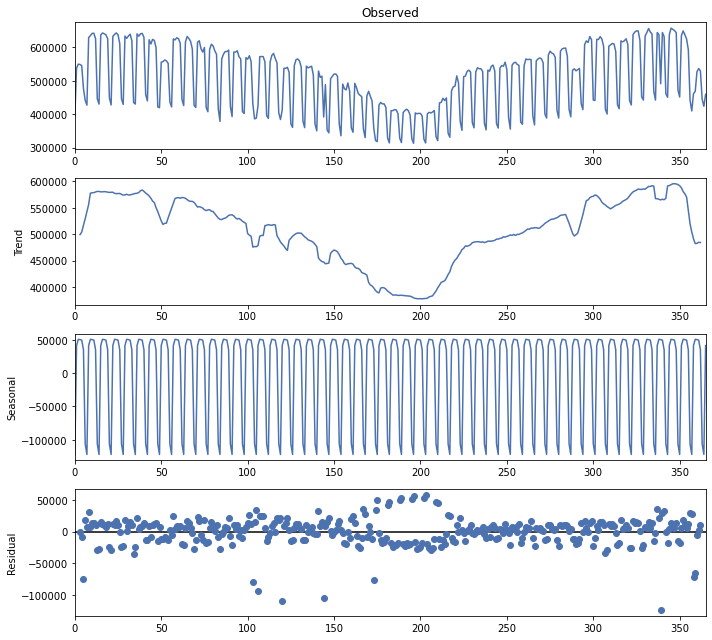

In [15]:
decompose = seasonal_decompose(ts2017.values, period = 7, model="additive")
plt.rcParams.update({'figure.figsize':(10,9)})
f = decompose.plot()

Now, we can see the trends and the seasonality clearly. Concerning the residuals, it resembles white noise to some extent, thus indicating that the model is a good fit. However, it also exhibits some abnormalities with clear patterns, especially in the summer period. This suggests that the residuals also erroneously take into account of the trend component - a "leakage". The problem mostly stems from this method of decomposition itself, being a very old and outdated technique. 

Fortunately, we can overcome this by substituting it for a novel, more sophisticated decomposition method called [STL decomposition](https://otexts.com/fpp2/stl.html). The technique is implemented in the class [STL](https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html) in the same package.

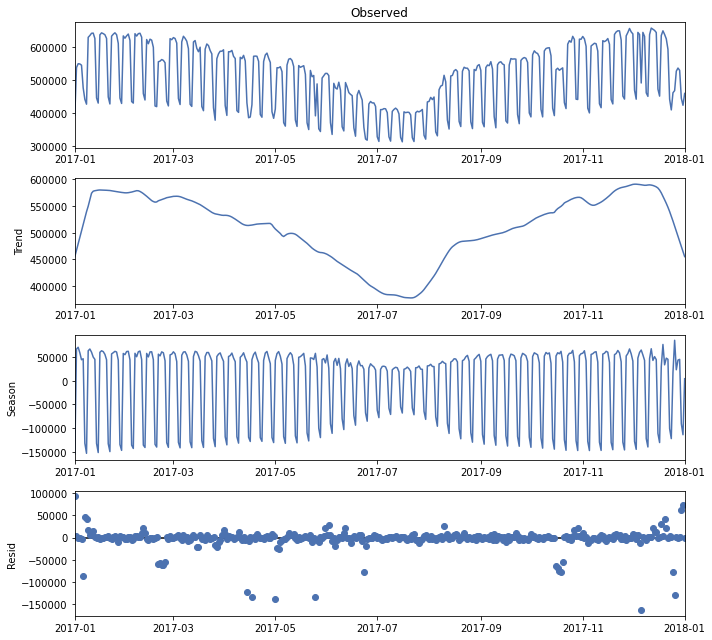

In [16]:
stl = STL(ts2017,seasonal=7,robust=True)
res = stl.fit()
fig = res.plot()

We can see that the quality of the decomposition is much better. That said, much of the patterns we have seen is still very much present. This means we have some detrending and deseasonalizing to do in the next step - modelling. 

## Baseline Model <a class="anchor" id="2."></a>

In every modeling process, there needs to be a baseline model whose results can be used to assess our more sophisticated models. Such a model should be easy to implement and can provide an adequate result. In this case, a simple linear regression model would suffice.

Conceptually, the energy consumption is the forecast variable $y$, while the time stamp is the predictor variable $x$ for this specific model. We can mathematically formulate the equation for this regression as follow
$$
y_t = \beta_0 + \beta_1 t + \epsilon_t,
$$
where $y_t$ is the data, and $t$ is the date time. 

In [17]:
# Basic imports
import numpy as np
import pandas as pd
from math import sqrt

# Machine learning basics
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn import datasets, linear_model

We start with splitting the data into train set and test set. To make the problem more challenging, we intentionally design our test set to be overlapped with the winter holiday season, which can help us more accurately judge the performance of the models when there is a strong presence of consecutive outliers.

In order to view both the [in-sample](https://otexts.com/fpp2/accuracy.html) and [out-of-sample](https://otexts.com/fpp2/accuracy.html) prediction, a part of the time series that contain both the data from the test set and train set is set aside, called `demo`. We will plot on the `demo` set in the end of this section.  

<AxesSubplot:xlabel='Date'>

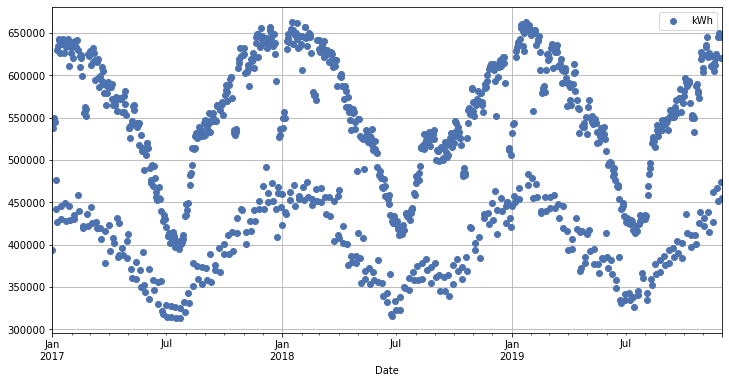

In [18]:
train_end = '2019-12-01'
test_end = '2020-01-01'
demo_start = '2019-11-25'
demo = ts[demo_start:test_end]
train,test = ts[:train_end], ts[train_end:]

train.plot(figsize=(12,6), style = 'o',grid=True)

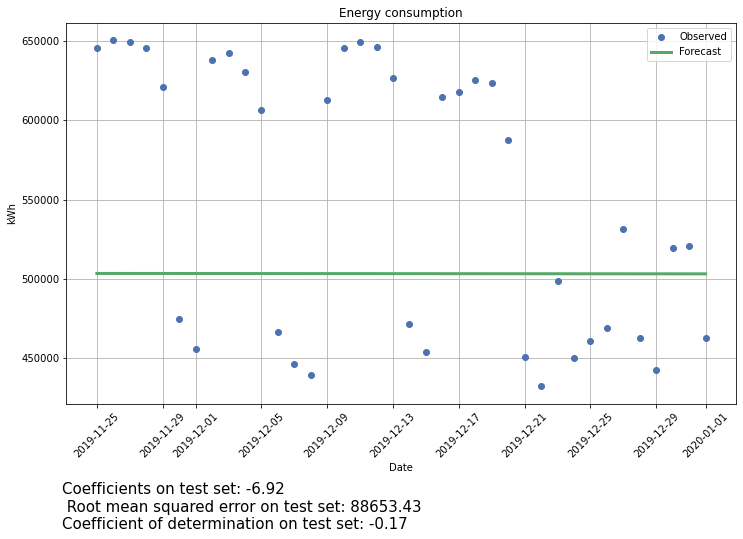

In [19]:
X = (train.index - train.index[0]).days.values.reshape(-1, 1)
y = train.kWh.values.reshape(-1, 1)

X_demo = (demo.index - train.index[0]).days.values.reshape(-1,1)
y_demo = demo.kWh.values.reshape(-1, 1)

X_test = (test.index - train.index[0]).days.values.reshape(-1,1)
y_test = test.kWh.values.reshape(-1, 1)

regr = linear_model.LinearRegression()
regr.fit(X,y)

regr_pred_demo = regr.predict(X_demo)
regr_pred_test = regr.predict(X_test)

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Energy consumption', xlabel='Date', ylabel='kWh')

ax.plot(demo.index, y_demo,'o')
ax.plot(demo.index, regr_pred_demo, linewidth=3)

err = 'Coefficients on test set: ' + str(round(regr.coef_.take(0).take(0),2)) + '\n Root mean squared error on test set: ' + \
    str(round(sqrt(MSE(y_test, regr_pred_test)),2)) + '\nCoefficient of determination on test set: ' + \
        str(round(r2_score(y_test, regr_pred_test), 2))

plt.figtext(0.12, -0.08, err, ha="left",fontsize=15,va='center')
plt.xticks(rotation=45)
legend = ax.legend(["Observed", "Forecast"])
ax.grid(True)

Now, we know that we need to do much better than a root mean squared error of 101,738 kWh!

## SARIMAX <a class="anchor" id="3."></a>

In [20]:
# Basic imports
import numpy as np
import pandas as pd
import datetime # manipulating date formats
import itertools
import time
import holidays
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as MAPE

# Stats packages
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### Model Identification <a class="anchor" id="3.1."></a>
Moving on to predicting the time series using SARIMAX models. Theoretically, they are simply combinations of Seasonal ARIMA with exogenous variables, which improves outliers modeling. One shorthand notation for the SARIMA model is
$$
\text{SARIMA } (p,d,q) \times (P,D,Q)S,
$$
where $p$ = non-seasonal autoregressive (AR) order, $d$ = non-seasonal differencing, $q$ = non-seasonal moving average (MA) order, $P$ = seasonal AR order, $D$ = seasonal differencing, $Q$ = seasonal MA order, and $S$ = time span of repeating seasonal pattern. The use of ARIMA models to fit a time series is called the [Box-Jenkins procedure](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method).

In order to apply the model, we first need to guarantee that the time series is stationary, or can be transformed into a stationary one. To simply put, a stationary time series is one whose properties is not dependent on time, with the mean, variance and autocorrelation structure do not change over time.

We can see from the initial plot that the time series is clearly not stationary, with visible seasonality and possibly trend. However, to be more precise, we can employ various stationarity tests. Here, the one we used is the [Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test), which is one of the commonly-used statistics.

In [21]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=7*4, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))

test_stationarity(ts.kWh)

Results of Dickey-Fuller Test:
Test Statistic                   -2.639
p-value                           0.085
#Lags Used                       28.000
Number of Observations Used    1067.000
Critical Value (1%)              -3.436
Critical Value (5%)              -2.864
Critical Value (10%)             -2.568
dtype: float64


We can see that the p-value is bigger than $\alpha = 0.05$. Therefore, the time series is unsurprisingly not stationary.  

In order to stationarize the data, we need to remove the trend and seasonal components. We can do that by differencing the data by the desired order of differencing. Intuitively, this is analogous to taking the derivatives of functions.

<AxesSubplot:xlabel='Date'>

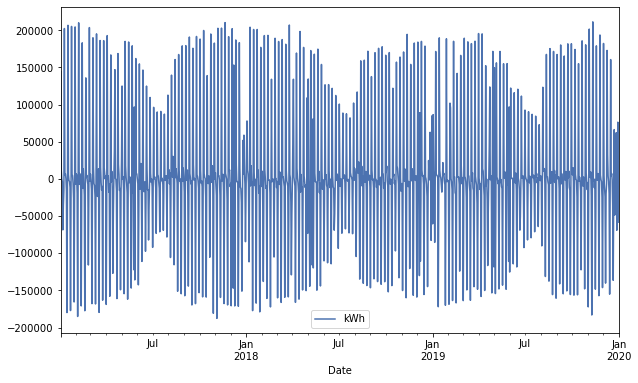

In [22]:
# invert differenced forecast
def invert_diff(series, first_element_before):
    cumsum = series.cumsum()
    return cumsum.fillna(0) + first_element_original

diffed = diff(ts,seasonal_periods=7)
diffed.plot(figsize=(10,6))

Now, the data looks much more appropriate for SARIMAX modeling. We can check again with the [Dickey-Fuller test](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html).

In [23]:
test_stationarity(diffed.kWh)

Results of Dickey-Fuller Test:
Test Statistic                   -6.859
p-value                           0.000
#Lags Used                       27.000
Number of Observations Used    1067.000
Critical Value (1%)              -3.436
Critical Value (5%)              -2.864
Critical Value (10%)             -2.568
dtype: float64


Since the p-value is much smaller than $\alpha = 0.05$, the differenced time series is stationary. It follows that the suitable values for the terms $d$ and $D$ are both 1.

We now proceed to check the correlation structure within the transformed data using [Autocorrelation Function (ACF)](https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.acf.html) and [Partial Autocorrelation Function (PACF)](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf.html) plots. This step is crucial in order to identify the suitable order of the AR and MA terms, both non-seasonal and seasonal.

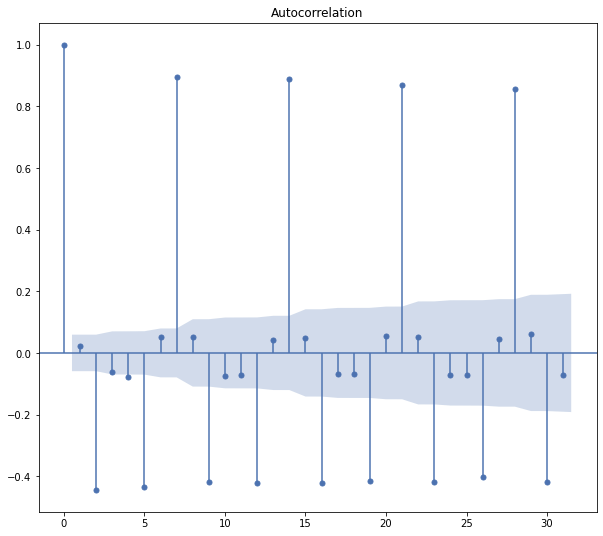

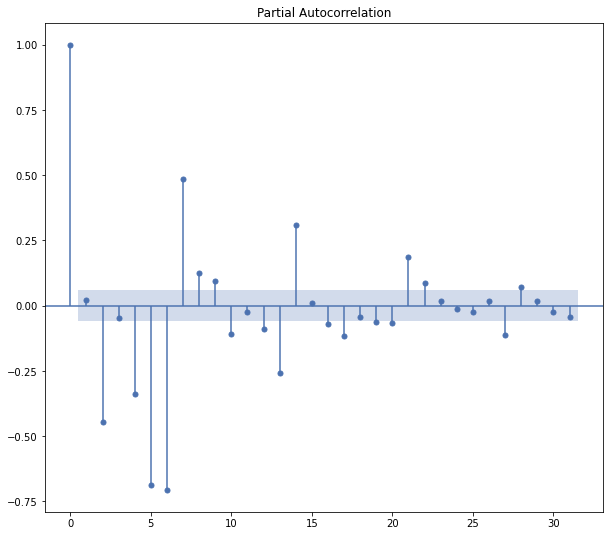

In [24]:
acf = plot_acf(diffed)
pacf = plot_pacf(diffed)

From the plots, a complex pattern with unexpected increases and decreases in the values of the functions can be found. Therefore, we cannot preclude any orders for the AR and MA terms. 

With regards to the seasonal terms, the plots show expected behaviours with spikes at lags equals to the number of days in a week. It can be hypothesized that P = 1 and Q = 2, with the tapering autocorrelation function and the sinusoidal shape of the partial autocorrelation function. Let us check our guesses in the next section where we apply the model.

### Model Estimation <a class="anchor" id="3.2."></a>

For the exogenous variables, one prime candidate is the date of holidays in Finland. We can procure such data using the [holidays package](https://pypi.org/project/holidays/).

In [25]:
begin = '2017-01-01'
abv = '2019-12-31'
hol = pd.to_datetime(holidays.CountryHoliday('Finland')[begin:abv])

exo = ts.copy()
exo["holidays"] = 0
exo.loc[hol] = 1

exo.drop(["kWh"],axis=1,inplace=True)
exo_train,exo_test = exo[:train_end],exo[train_end:abv]
exo_test[:10]

,holidays
Date,
2019-12-01,0
2019-12-02,0
2019-12-03,0
2019-12-04,0
2019-12-05,0
2019-12-06,1
2019-12-07,0
2019-12-08,0
2019-12-09,0


Now we can finally get to apply the model. In order to expedite the process, we can use the Grid Search method, which involves experimenting with many different parameters and selecting the best by a loss function. For ARIMA models, Akaike Information Criterion (AIC) is a widely used estimator, and we will also use it for this task. 

In [26]:
def sarimax(ts,exo,all_param):
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(ts,
                          exog = exo,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
        except Exception as e:
            print(e)
            continue
            
    return results

In [27]:
# set parameter range
p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[7]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

all_res = sarimax(train,exo_train,all_param)

Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 7) - AIC:31259.07
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 7) - AIC:24640.34
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 7) - AIC:24624.16
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 7) - AIC:24754.79
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 7) - AIC:24586.39
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 7) - AIC:24569.56
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 7) - AIC:24701.83
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 7) - AIC:24570.74
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 7) - AIC:24587.37
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:24823.7
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 7) - AIC:24585.39
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 7) - AIC:24574.37
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 7) - AIC:24661.13
Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 7) - AIC:24554.85
Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 7) - AIC:24542.64
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 7) - AIC:24614.24
Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 7) - AIC:24545.54
Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 7) - AIC:24544.29
Tried out S

We can see that there is not a big variation between the AICs, i.e. most of the models are of similar quality. Let us list the estimated best models.

In [28]:
all_res.sort(key=lambda x: x[1])
all_res[:5]

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2eada5156d0>,
  24513.320903805343,
  ((1, 1, 2), (1, 1, 2, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2ea73ef8ac0>,
  24513.95207335959,
  ((0, 1, 2), (1, 1, 2, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2eaffef6e80>,
  24514.127795680713,
  ((2, 1, 2), (1, 1, 2, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2eaed8d8670>,
  24515.033250992434,
  ((1, 1, 2), (2, 1, 2, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2eb25ff5550>,
  24515.561430520036,
  ((2, 1, 1), (1, 1, 2, 7)))]

According to the AIC score, the best model to choose is
$$
\text{SARIMA } (1,1,2) \times (1,1,2)7.
$$

Even though the [parsimony principle](http://rpierse.esy.es/rpierse/files/fe2.pdf) is violated for this model, the margin is small enough, and we can gain from some flexibility.

### Model Validation <a class="anchor" id="3.3."></a>

To determine the goodness of fit of the model, we can examine its residuals using the standard assumption: the error term $\epsilon_t$ should be white noise drawings from a fixed distribution with a constant mean and variance.

We can check this by looking at the various plots showing the distribution of the residuals. In addition, the Ljung-box test can also be used to do this more precisely. 

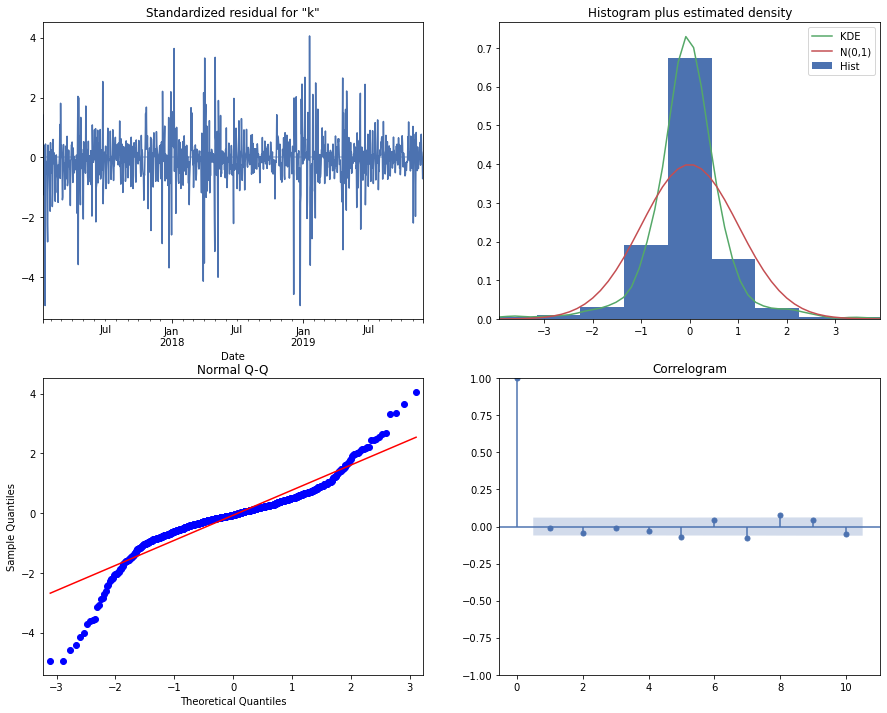

Ljung-box p-values:
[0.67721521 0.31963045 0.49660402 0.51013043 0.13165714 0.0922102
 0.01728597 0.00318366 0.00267157 0.00169986 0.00163678 0.00219893
 0.00374616 0.00203584]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               kWh   No. Observations:                 1065
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 7)   Log Likelihood              -12248.660
Date:                           Fri, 22 Jan 2021   AIC                          24513.321
Time:                                   19:57:58   BIC                          24553.026
Sample:                               01-01-2017   HQIC                         24528.371
                                    - 12-01-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holidays   -6.638e+04   3166.364    -20.965      0.000   -7.26e+04   -6.02e+04
ar.L1         -0.1796      0.208     -0.865      0.387      -0.586       0.227
ma.L1         -0.0816      0.210     -0.388      0.698      -0.494       0.330
ma.L2         -0.2114      0.065     -3.269      0.001      -0.338      -0.085
ar.S.L7        0.6702      0.052     12.914      0.000       0.569       0.772
ma.S.L7       -1.2942      0.060    -21.595      0.000      -1.412      -1.177
ma.S.L14       0.3010      0.047      6.353      0.000       0.208       0.394
sigma2      8.962e+08      0.013   6.86e+10      0.000    8.96e+08    8.96e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              2419.63
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                            -0.81
Prob(H) (two-sided):                  0.57   Kurtosis:                        10.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.76e+27. Standard errors may be unstable.
"""

In [29]:
res = all_res[0][0]
res.plot_diagnostics(figsize=(15, 12))

plt.show()
print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))
res.summary()

From the plots, the residuals seem to be normally distributed around 0 - which is the condition that we need - with slightly heavy tails. However, looking at the Ljung box statistics, we cannot reject the hypothesis that the data are not independently distributed, since the p-values are smaller than $\alpha = 0.05$ for some lags from 6 onwards. 

Nevertheless, let us use this model to predict on the test set and judge it for ourselves.

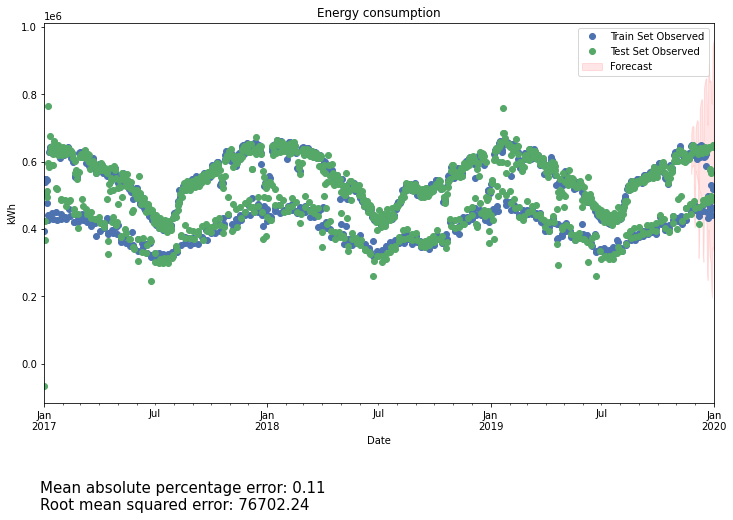

In [30]:
pred_test = res.get_prediction(start=train_end,end=test_end,exog=exo_test)
err = 'Mean absolute percentage error: %.2f'% MAPE(test, pred_test.predicted_mean) + \
'\nRoot mean squared error: %.2f'% sqrt(MSE(test, pred_test.predicted_mean))

pred = res.get_prediction(start=begin,end=test_end,exog=exo_test)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Energy consumption', ylabel='kWh')

ts.plot(ax=ax, style = 'o')
pred.predicted_mean.plot(ax=ax, style='o')
ci = pred_ci.loc[demo_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])

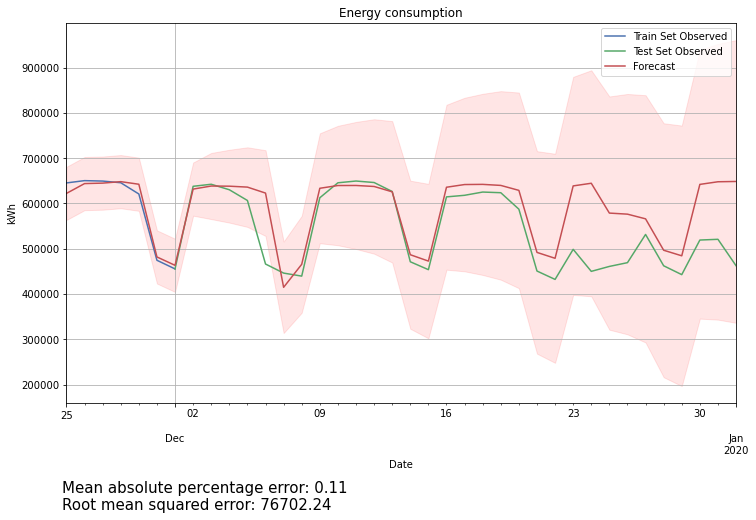

In [31]:
pred_test = res.get_prediction(start=train_end,end=test_end,exog=exo_test)
# The root mean squared error
err = 'Mean absolute percentage error: %.2f'% MAPE(test, pred_test.predicted_mean) + \
'\nRoot mean squared error: %.2f'% sqrt(MSE(test, pred_test.predicted_mean))

pred = res.get_prediction(start=demo_start,end=test_end,exog=exo_test)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Energy consumption', ylabel='kWh')

train[demo_start:].plot(ax=ax)
test.plot(ax=ax)
pred.predicted_mean.plot(ax=ax)
ci = pred_ci.loc[demo_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])
ax.grid(True)

The result looks very satisfactory! During the first 2 weeks of the month, the forecasted values fit well to the actual ones, possibly with the exception of the 6th of December - the Independence day of Finland.

With regards to the winter holiday season, the model unfortunately did not do as well. Contrary to the first 2 weeks, the only day where the values are more accurately predicted is the 27th, despite the addition of the "holiday" variable. This shows the challenges of forecasting during exceptional time periods. Nevertheless, the model still show promises in forecasting when the data behaves predictably.

## LSTM <a class="anchor" id="4."></a> 

In [32]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import datetime # manipulating date formats
import holidays
import torch
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score
from torch.autograd import Variable
from fastprogress import master_bar, progress_bar
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as MAPE
from torch.autograd import Variable

# settings
plt.style.use('seaborn-deep')
import warnings
warnings.filterwarnings("ignore")

### Feature Engineering <a class="anchor" id="4.1."></a>

By preparing the data well in advance, we can help simplify models and improve their performance by a great extent with comparatively little effort. This means to come up with better representations of data or adding more useful information, i.e. to engineer features.

#### Holidays Data Generation <a class="anchor" id="4.1.1."></a>

To get started, the exogenous 'holiday' variable can be reused entirely from the SARIMAX model.

In [33]:
import holidays

begin = '2017-01-01'
end = '2019-12-31' # errors within the holidays package
hol = pd.to_datetime(holidays.CountryHoliday('Finland')[begin:end])

exo = ts.copy()
exo["holidays"] = 0
exo.loc[hol] = 1
exo.loc["2020-01-01","holidays"] = 1

ts["holidays"] = exo["holidays"]
ts

,kWh,holidays
Date,,
2017-01-01,393707.05,1
2017-01-02,538022.63,0
2017-01-03,549714.09,0
2017-01-04,548953.12,0
2017-01-05,545259.28,0
...,...,...
2019-12-28,462485.64,0
2019-12-29,442889.22,0
2019-12-30,519266.06,0


#### Cyclical feature encoding <a class="anchor" id="4.1.2."></a>

The separate datetime data on its own is not very useful to the learning task. Therefore, we need a way to encode the periodicity of the time series from our knowledge into the data. This can be achieved by modelling time as a circular scale, which is simply mapping the date time values using trigonometric functions.

In [34]:
date = ts.index
timestamp_s = date.map(datetime.datetime.timestamp)

In [35]:
week = 7*24*60*60
ts['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
ts['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))

Text(0.5, 1.0, 'Time of week signal')

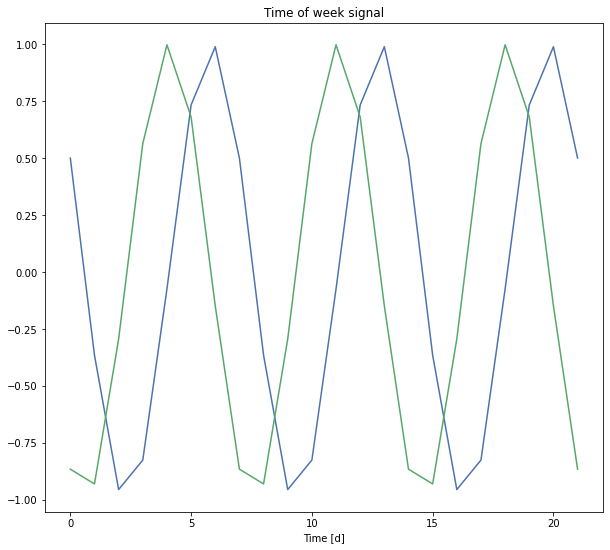

In [36]:
plt.plot(np.array(ts['Week sin'])[:22])
plt.plot(np.array(ts['Week cos'])[:22])

plt.xlabel('Time [d]')
plt.title('Time of week signal')

In [37]:
ts.head(10)

,kWh,holidays,Week sin,Week cos
Date,,,,
2017-01-01,393707.05,1,0.500000,-0.866025
2017-01-02,538022.63,0,-0.365341,-0.930874
2017-01-03,549714.09,0,-0.955573,-0.294755
2017-01-04,548953.12,0,-0.826239,0.563320
2017-01-05,545259.28,0,-0.074730,0.997204
2017-01-06,476644.64,1,0.733052,0.680173
2017-01-07,441790.83,0,0.988831,-0.149042
2017-01-08,427113.22,0,0.500000,-0.866025
2017-01-09,629581.78,0,-0.365341,-0.930874


In [38]:
ts.describe()

,kWh,holidays,Week sin,Week cos
count,1096.000000,1096.000000,1096.000000,1096.000000
mean,508050.718476,0.028285,-0.001503,-0.001394
std,94631.972830,0.165861,0.707415,0.707442
min,313056.850000,0.000000,-0.955573,-0.943883
25%,428946.617500,0.000000,-0.826239,-0.846724
50%,522296.615000,0.000000,-0.111964,-0.111964
75%,589724.655000,0.000000,0.707107,0.680173
max,663211.580000,1.000000,0.993712,0.997204


### Feature Vector Normalization <a class="anchor" id="4.1.3."></a>

Since there are big discrepancies between the scales of the different features, we need to normalize them into a common scale, without distorting the differences in the ranges of values or losing information.

In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_kwh = MinMaxScaler(feature_range=(0, 1)).fit(ts[["kWh"]])
ts_normalized = pd.DataFrame(scaler.fit_transform(ts),
                             columns = ts.columns.values,
                            index = ts.index)

In [40]:
ts_normalized

,kWh,holidays,Week sin,Week cos
Date,,,,
2017-01-01,0.230327,1.0,7.467214e-01,0.040110
2017-01-02,0.642475,0.0,3.027940e-01,0.006702
2017-01-03,0.675865,0.0,7.915890e-14,0.334415
2017-01-04,0.673692,0.0,6.634947e-02,0.776474
2017-01-05,0.663142,0.0,4.518799e-01,1.000000
...,...,...,...,...
2019-12-28,0.426751,0.0,9.974958e-01,0.409482
2019-12-29,0.370786,0.0,7.467214e-01,0.040110
2019-12-30,0.588909,0.0,3.027940e-01,0.006702


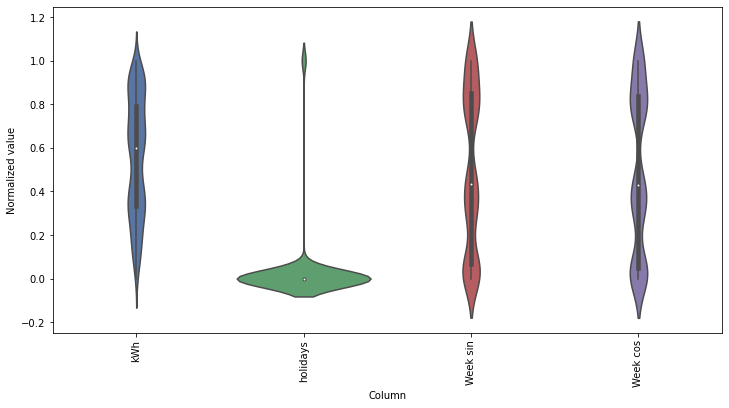

In [41]:
melt_plot = ts_normalized.melt(var_name='Column', value_name='Normalized value')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized value', data=melt_plot)
_ = ax.set_xticklabels(ts_normalized.keys(), rotation=90)

## Modeling <a class="anchor" id="4.2."></a>

Certainly, we need to split the dataset into train, validation, and test sets first. The test set here will be of the same time period as the one in the SARIMAX model, so we can compare the performance more easily.

In [42]:
train_end = '2019-12-01'
test_end = '2020-01-01'
demo_start = '2019-11-25'

test_df = ts_normalized[train_end:]
train_val = ts_normalized[:train_end]

n = len(train_val)

train_df = train_val[:int(n*0.8)]
val_df = train_val[int(n*0.8):]

column_indices = {name: i for i, name in enumerate(ts.columns)}
num_features = ts.shape[1]
train_df

,kWh,holidays,Week sin,Week cos
Date,,,,
2017-01-01,0.230327,1.0,7.467214e-01,4.011047e-02
2017-01-02,0.642475,0.0,3.027940e-01,6.702214e-03
2017-01-03,0.675865,0.0,7.915890e-14,3.344147e-01
2017-01-04,0.673692,0.0,6.634947e-02,7.764738e-01
2017-01-05,0.663142,0.0,4.518799e-01,1.000000e+00
...,...,...,...,...
2019-04-28,0.187630,0.0,7.631541e-01,5.005398e-02
2019-04-29,0.677977,0.0,3.207811e-01,2.004508e-13
2019-04-30,0.623426,0.0,5.996802e-03,3.161137e-01


In order for the LSTM to work, we need to create sliding windows from the data so that for each datapoint, its features is the window of a determined size of the past values . In this project, the width of the features vector is 28 days, or 4 weeks, while there is only one label for each window. 

<img src="https://github.com/quan-possible/energy-demand-prediction/blob/main/daily/data_window.png?raw=true" alt="A window of data">

In [43]:
def split_sequence(df, fea_width=28, label_width=1, shift=1, label_col_indices=[0]):
    
    """ Split sequence with sliding window into
        sequences of context features and label.
        Args:
            df (DataFrame): the target time series
            fea_width (int): Length of features vector.
            label_width (int): Length of labels vector.
            shift (int): Distance between the features vector and the labels one. 
            label_col_indices (list(int)): list of the columns for the labels.
            ra
        Return:
            X (np.array): sequence of features
            y (np.array): sequence of labels
    """
    arr = df.to_numpy()

    # Work out the label column indices.

    window_size = fea_width + shift + label_width - 1
    fea_slice = slice(0, fea_width)
    fea_indices = np.arange(window_size)[fea_slice]

    label_slice = slice(window_size - label_width, None)
    label_indices = np.arange(window_size)[label_slice]
    
    
    print("\n window_size: {} \n fea_indices: {} \n label_indices: {}"
          .format(window_size,fea_indices,label_indices))
    
    
    def split_window(window):
        features = window[fea_slice]
        labels = window[label_slice]
#         print(label_col)
#         print([label_col_indices[name] for name in label_col])
        if label_col_indices is not None:
            labels = np.stack(
                [labels[:, label_col_indices[idx]] 
                 for idx in label_col_indices],
                axis=-1)
        
        labels = labels.flatten()
        
        return features, labels
            
    n = len(arr)
    X,y = list(),list()
    for i in range(0, n, shift):
        
        window = arr[i:i+window_size]
        if (len(window) != window_size): break
        
        # Find the end of this pattern:
        features,labels = split_window(window)
        X.append(features)
        y.append(labels)
        
#     print(label_col_indices)
#     if randomize == True:
#         random.shuffle(X)
#         random.shuffle(y)
    
    return X,y

In [44]:
fea_width, label_width, shift, label_col_indices = 28, 1, 1, [0]

X_ts,y_ts = split_sequence(ts_normalized)

X_train,y_train = split_sequence(train_df)
X_val,y_val = split_sequence(val_df)
X_test,y_test = split_sequence(test_df)

X_train[0].shape,y_train[0].shape


 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]


((28, 4), (1,))

The only secondary step left is to convert the data into Pytorch Tensors.

In [45]:
def to_tensor(ls):
    return Variable(torch.cuda.FloatTensor(np.array(ls)))

X_ts,y_ts = to_tensor(X_ts),to_tensor(y_ts)

X_train,y_train = to_tensor(X_train),to_tensor(y_train)
X_val,y_val = to_tensor(X_val),to_tensor(y_val)
X_test = to_tensor(X_test)

X_train

tensor([[[2.3033e-01, 1.0000e+00, 7.4672e-01, 4.0110e-02],
         [6.4248e-01, 0.0000e+00, 3.0279e-01, 6.7022e-03],
         [6.7586e-01, 0.0000e+00, 7.9159e-14, 3.3441e-01],
         ...,
         [9.2681e-01, 0.0000e+00, 4.5188e-01, 1.0000e+00],
         [8.5173e-01, 0.0000e+00, 8.6628e-01, 8.3667e-01],
         [3.7862e-01, 0.0000e+00, 9.9750e-01, 4.0948e-01]],

        [[6.4248e-01, 0.0000e+00, 3.0279e-01, 6.7022e-03],
         [6.7586e-01, 0.0000e+00, 7.9159e-14, 3.3441e-01],
         [6.7369e-01, 0.0000e+00, 6.6349e-02, 7.7647e-01],
         ...,
         [8.5173e-01, 0.0000e+00, 8.6628e-01, 8.3667e-01],
         [3.7862e-01, 0.0000e+00, 9.9750e-01, 4.0948e-01],
         [3.3198e-01, 0.0000e+00, 7.4672e-01, 4.0110e-02]],

        [[6.7586e-01, 0.0000e+00, 7.9159e-14, 3.3441e-01],
         [6.7369e-01, 0.0000e+00, 6.6349e-02, 7.7647e-01],
         [6.6314e-01, 0.0000e+00, 4.5188e-01, 1.0000e+00],
         ...,
         [3.7862e-01, 0.0000e+00, 9.9750e-01, 4.0948e-01],
         [

We now can finally get to building the neural network! Our model has 2 hidden LSTM layers with 512 neurons each. The input and output layers has 4 and 1 nodes corresponding to the shape of the features and labels vector respectively. The Adam optimizer is used, and the learning rate is dynamically modified using a scheduler.

The architecture is inspired by [OmerS. Learning Pytorch LSTM Deep Learning with M5 Data](https://www.kaggle.com/omershect/learning-pytorch-lstm-deep-learning-with-m5-data).

In [46]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
        
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
        
       
        _, (hn, cn) = self.LSTM(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
num_epochs = 300
learning_rate = 1e-3
input_size = 4
hidden_size = 512
num_layers = 2

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers)
model.cuda()


model.apply(init_weights)

criterion = torch.nn.MSELoss().cuda()    # Will be transformed to root mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [47]:
for epoch in progress_bar(range(1,num_epochs+1)):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    
    loss = torch.sqrt(criterion(y_pred, y_train))
    loss.backward()
    
    optimizer.step()
    
    model.eval()
    valid = model(X_val)
    val_loss = torch.sqrt(criterion(valid, y_val))
    scheduler.step(val_loss)
    
    if epoch%20 == 1:
        print("Epoch: %d, loss: %1.5f validation loss:  %1.5f " 
              %(epoch, loss.item(),val_loss.item()))

print("Final: \nEpoch: %d, loss: %1.5f validation loss:  %1.5f " 
              %(epoch, loss.item(),val_loss.item()))

Epoch: 1, loss: 0.63244 validation loss:  0.30838 
Epoch: 21, loss: 0.15830 validation loss:  0.15350 
Epoch: 41, loss: 0.14124 validation loss:  0.12848 
Epoch: 61, loss: 0.13214 validation loss:  0.11443 
Epoch: 81, loss: 0.09786 validation loss:  0.07861 
Epoch: 101, loss: 0.08649 validation loss:  0.05874 
Epoch: 121, loss: 0.08123 validation loss:  0.05096 
Epoch: 141, loss: 0.07777 validation loss:  0.04442 
Epoch: 161, loss: 0.07651 validation loss:  0.04426 
Epoch: 181, loss: 0.07473 validation loss:  0.04543 
Epoch: 201, loss: 0.07185 validation loss:  0.04300 
Epoch: 221, loss: 0.06986 validation loss:  0.04042 
Epoch: 241, loss: 0.06834 validation loss:  0.03962 
Epoch: 261, loss: 0.06709 validation loss:  0.04418 
Epoch: 281, loss: 0.06476 validation loss:  0.04164 
Final: 
Epoch: 300, loss: 0.06227 validation loss:  0.04138 


So far, so good. Now we need to check the error of the model on the test set without normalization. 

In [48]:
model.eval()

## Inverse Normalize 
y_test_pred = scaler_kwh.inverse_transform(model(X_test).cpu().detach().numpy())
y_test_obs = scaler_kwh.inverse_transform(y_test)

print('The root mean squared error of the model is ' +
      str(round(np.sqrt(MSE(y_test_obs,y_test_pred)),2)) +
      '\nThe root mean squared error of the model is ' + 
     str(round(MAPE(y_test_obs,y_test_pred),2)))

The root mean squared error of the model is 66634.48
The root mean squared error of the model is 0.12


This is only a marginal improvement over the SARIMAX model. In fact, we can see that the LSTM model performs worse than the classical method after accounting for the far greater level of complexity of the Deep Neural Networks. This is in agreement with the literature on time series forecasting, with deep learning methods having not delivered on their promises.

Nevertheless, we can further examine the fitness of the model on the data by visualizing the results, starting with the all the data available.

Text(0, 0.5, 'kWh')

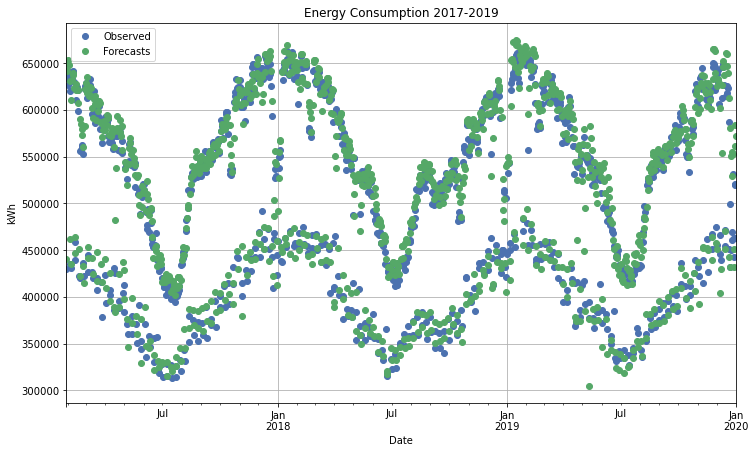

In [49]:
y_pred = scaler_kwh.inverse_transform(model(X_ts).cpu().detach().numpy())
y_obs = scaler_kwh.inverse_transform(y_ts.cpu().numpy())

pred_df = pd.DataFrame(y_pred,index = ts.index[-len(y_pred):],columns = ["kWh"])
obs_df = pd.DataFrame(y_obs,index = ts.index[-len(y_pred):],columns = ["kWh"])

fig, ax = plt.subplots()
plot_df = pd.concat([obs_df,pred_df],axis=1)
plot_df.plot(ax=ax,figsize=(12,7),style = 'o', grid=True)
ax.legend(["Observed", "Forecasts"])
ax.set_title("Energy Consumption 2017-2019")
ax.set_ylabel("kWh")

The forecasts appear to fit the observed values well, but is worse than that of the SARIMA with consistent under-prediction of the max values. Let us look at the prediction on the test set compare it with that of the SARIMAX.

Text(0, 0.5, 'kWh')

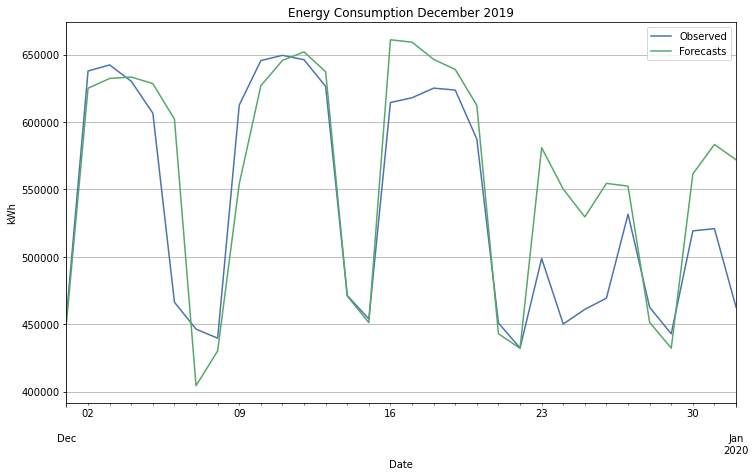

In [50]:
fig, ax = plt.subplots()
plot_df.loc[train_end:].plot(ax = ax, figsize=(12,7), grid=True)

ax.legend(["Observed", "Forecasts"])
ax.set_title("Energy Consumption December 2019")
ax.set_ylabel("kWh")

Despite better fitness during some time points, the model consistently under-predict the values by a wide margin. Concerning the holiday period, the forecasts still have the same defects as that of the SARIMAX model.

In conclusion, even though the presented models have presented reasonable accuracy, time series forecasting still presents many challenges. That said, this is still a very active research area, offering much improvement in the future.

# Further Readings <a class="anchor" id="5."></a>

* [Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition. *OTexts: Melbourne, Australia*](https://otexts.com/fpp2/)
* [Shumway, R., & Stoffer, D. (2017). Time Series Analysis and Its Applications. *Springer Texts In Statistics*. https://doi.org/10.1007/978-3-319-52452-8](https://www.springer.com/gp/book/9783319524511)
*[SARIMAX: Introduction. *Statsmodels.org. (2021)*. Retrieved 17 January 2021.](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html.)
* [NIST/SEMATECH e-Handbook of Statistical Methods. Retrieved 17 January 2021.](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc445.htm)
* [Time series forecasting: TensorFlow Core.](https://www.tensorflow.org/tutorials/structured_data/time_series#feature_engineering)
* [Zhang, G. (2012). Neural Networks for Time-Series Forecasting. *Handbook of Natural Computing*, 461–477.](https://link.springer.com/referenceworkentry/10.1007%2F978-3-540-92910-9_14#citeas)